In [11]:
import networkx as nx # make sure you installed networkx
import pandas as pd
import numpy as np

# Graph including only positive corsi influences
# Read in data
df = pd.read_csv("../../data/forwards/forwards_edgelist_corsi.csv")

# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'cf_inf_on2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','cf_inf_on1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)


# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)
player_names = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_name = players_df.loc[[player]]["playerName"].values[0]
    player_names[player] = player_name

nx.set_node_attributes(G, player_names, "playerName")

# NOTE: this uses data calculated in defense-overall.ipynb
# average corsi influence
players_avg_TOI_dict = dict.fromkeys(G.nodes)
for player in G.nodes:
    player_avg_TOI = players_df.loc[[player]]["average_corsi_influence"].values[0]
    players_avg_TOI_dict[player] = player_avg_TOI

nx.set_node_attributes(G, players_avg_TOI_dict, "average_corsi_influence")


In [12]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)

Number of nodes:  758
Number of edges:  4442


In [13]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
greedy_communities = nxc.greedy_modularity_communities(G, weight='weight')

# add community info to node attributes
i = 0
greedy_communities_dict = dict.fromkeys(G.nodes)
for community in greedy_communities:
    for player in community:
        greedy_communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, greedy_communities_dict, "greedy_community")

# output a gephi file for ez visualization
nx.write_gexf(G, 'forwards-positive.gexf')

In [14]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)

# Remove players with less than 20 games to clean up playerbase data a bit
players_df = players_df.drop(players_df[players_df.games_played < 20].index)

In [17]:
def plot_distributions(stat):
    # Plot corsi influence distribution of entire playerbase
    playerbase_stats = players_df[stat].values
    print("n: ", len(playerbase_stats))
    print("mean: ", np.nanmean(playerbase_stats))
    print("std dev: ",np.nanstd(playerbase_stats))
    n, bins, patches = plt.hist(playerbase_stats, 30)
    plt.xlabel(stat)
    plt.ylabel("Count")
    plt.title("Overall Playerbase " + stat)
    plt.show()

    # Plot corsi distribution of each community individually
    i = 0
    for community in greedy_communities:
        players_stats = []
        for player in community:
            players_stats.append(players_df.loc[player][stat])
        print("n: ", len(players_stats))
        print("mean: ", np.mean(players_stats))
        print("std dev: ",np.std(players_stats))
        plt.hist(players_stats, bins)
        plt.xlabel(stat)
        plt.ylabel("Count")
        title = "Community: " + str(i)
        plt.title(title)
        plt.show()
        i += 1

n:  1159
mean:  1.9713099616650176
std dev:  0.7857278508250107


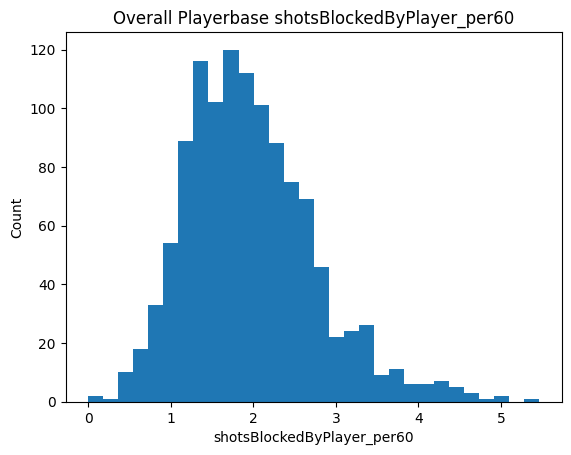

n:  66
mean:  1.8873520638149515
std dev:  0.7374301948346439


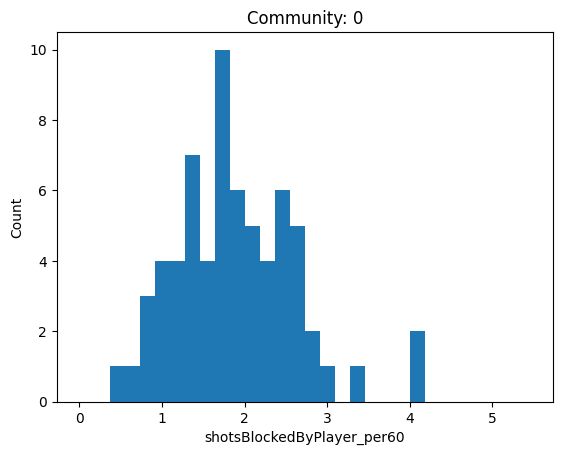

n:  63
mean:  1.7305992299291362
std dev:  0.5713381145682016


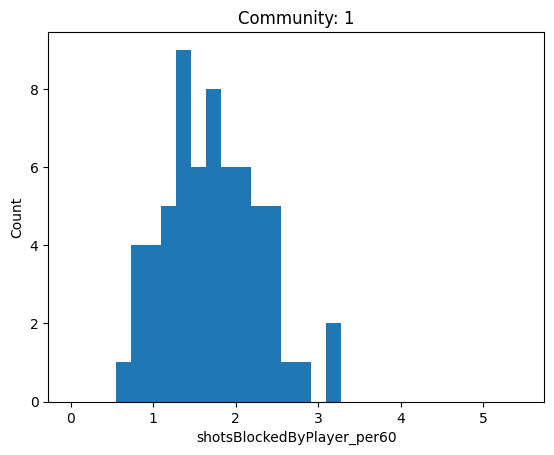

n:  57
mean:  1.8518795357610656
std dev:  0.6496619302112985


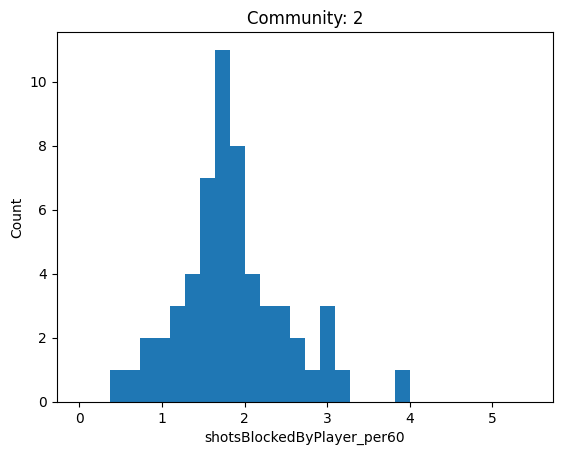

n:  56
mean:  1.9081156219118807
std dev:  0.6956301852094713


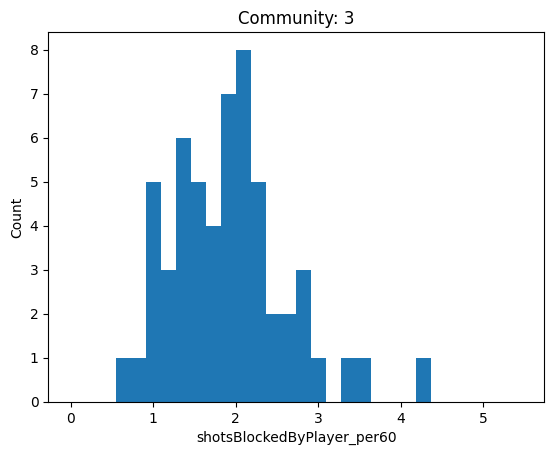

n:  55
mean:  1.8427635970863288
std dev:  0.6398397521831748


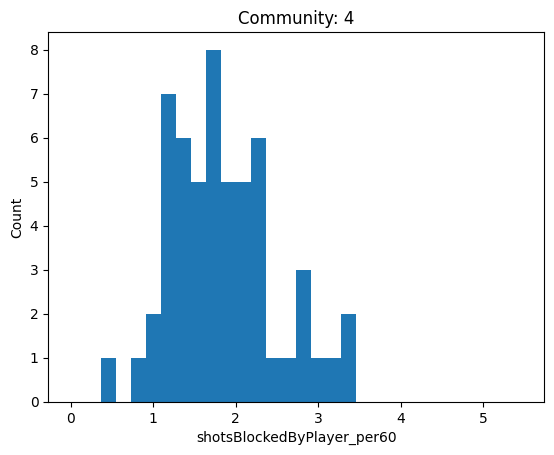

n:  54
mean:  1.9137632711289052
std dev:  0.6812542695082447


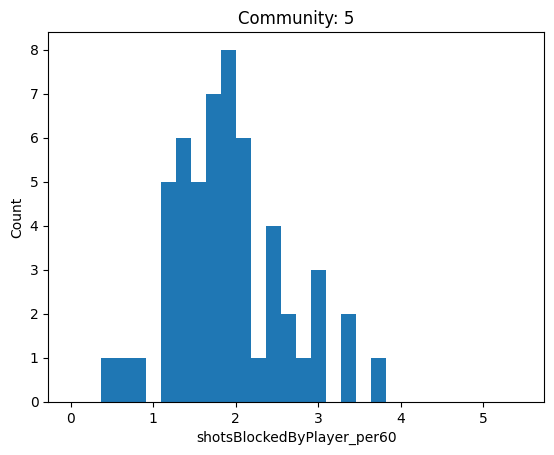

n:  51
mean:  2.005249384126579
std dev:  0.6509560680443925


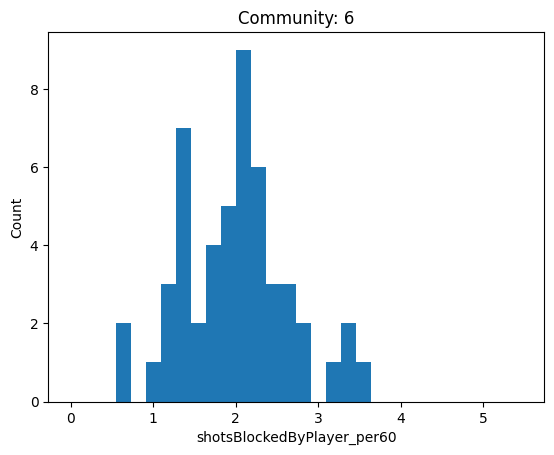

n:  50
mean:  1.8745185494697127
std dev:  0.6003377449524532


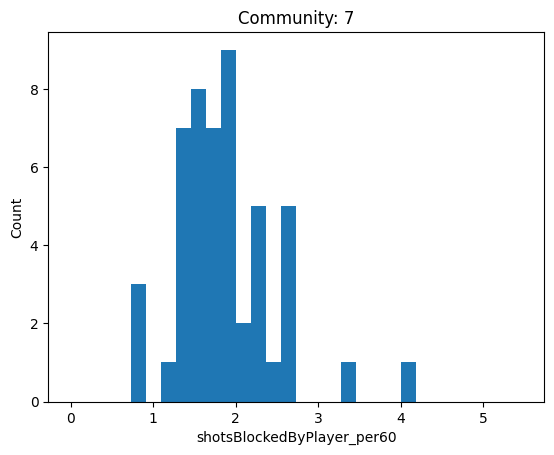

n:  45
mean:  1.8211808991947696
std dev:  0.5961059019945781


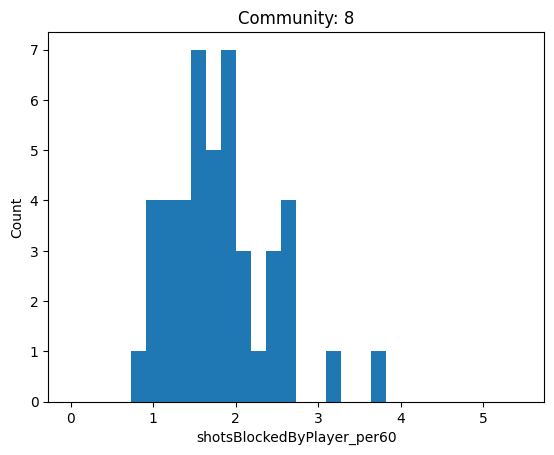

n:  39
mean:  1.954995990720193
std dev:  0.6155813646679853


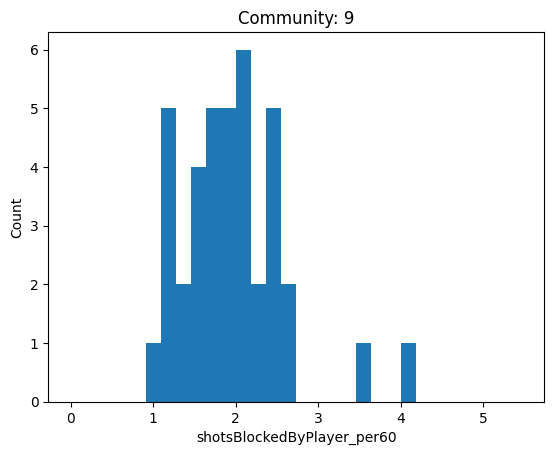

n:  38
mean:  1.9280818905286197
std dev:  0.6689050998380822


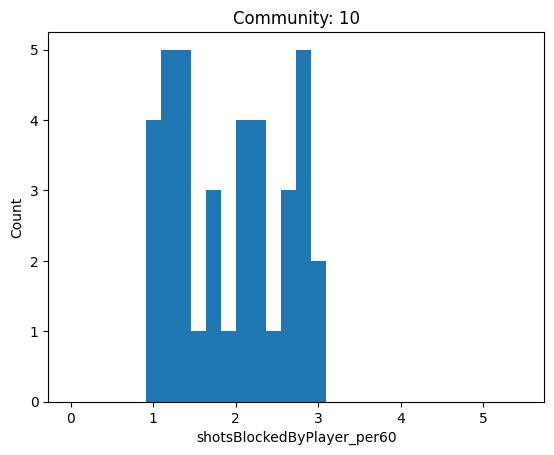

n:  37
mean:  1.902422140461871
std dev:  0.5999567840906627


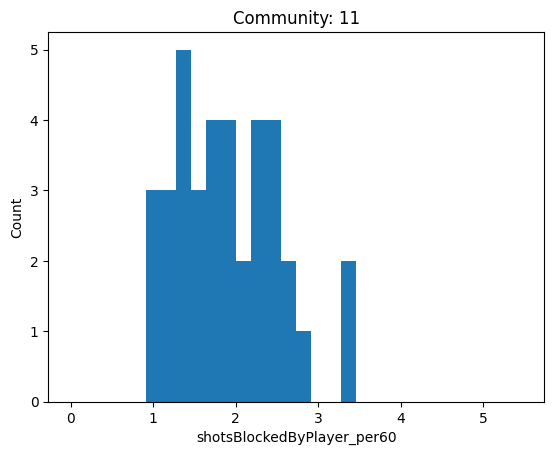

n:  36
mean:  1.5531832693413243
std dev:  0.6139832820104532


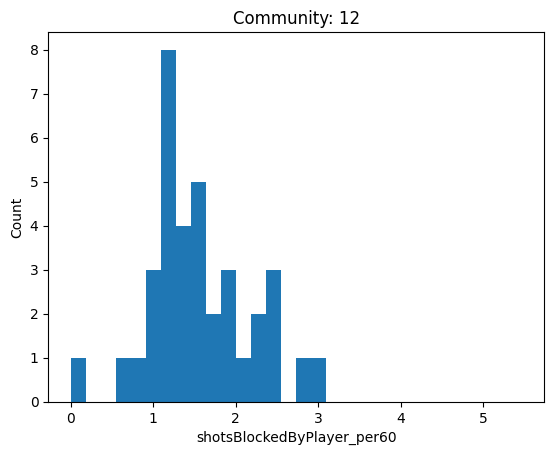

n:  28
mean:  1.7967072497163439
std dev:  0.49184246515601937


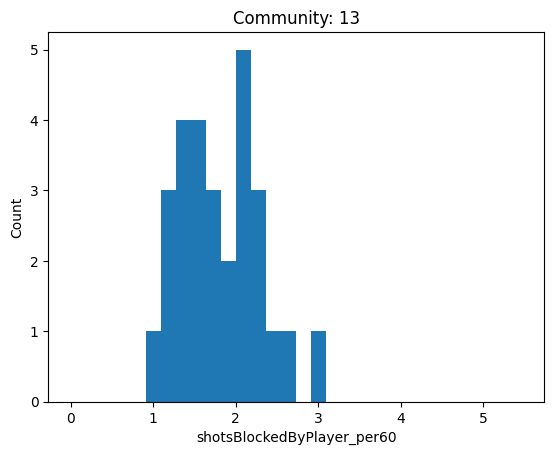

n:  27
mean:  2.1146964424687
std dev:  0.6660559196095421


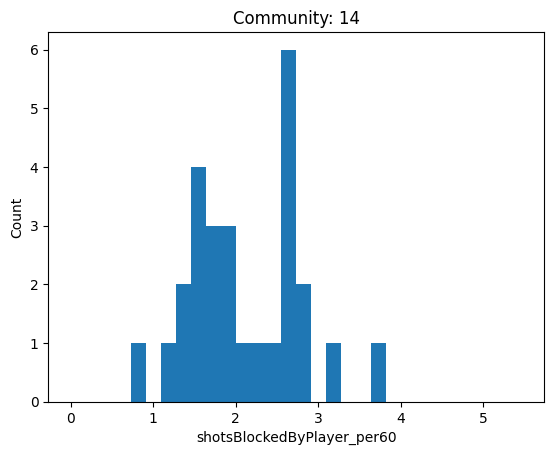

n:  19
mean:  1.8650352552607743
std dev:  0.7018960773254586


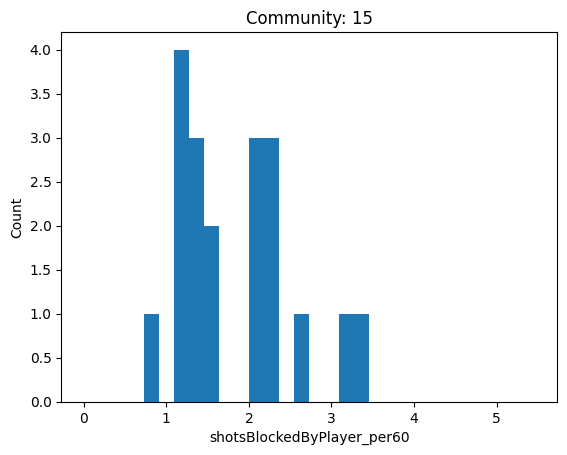

n:  17
mean:  1.849663700272556
std dev:  0.7042565072116778


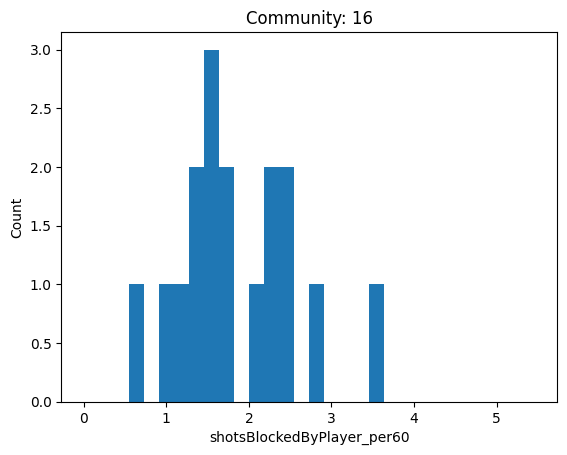

n:  9
mean:  1.9955880245284472
std dev:  0.49445418106509226


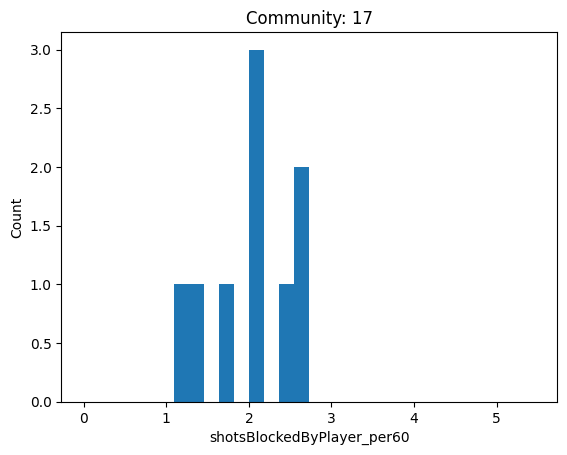

n:  8
mean:  2.851443582635949
std dev:  0.7419756195553286


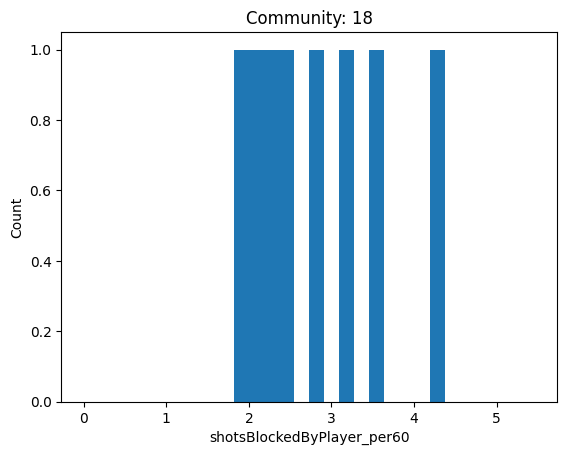

n:  3
mean:  1.0094143724710076
std dev:  0.148535820980607


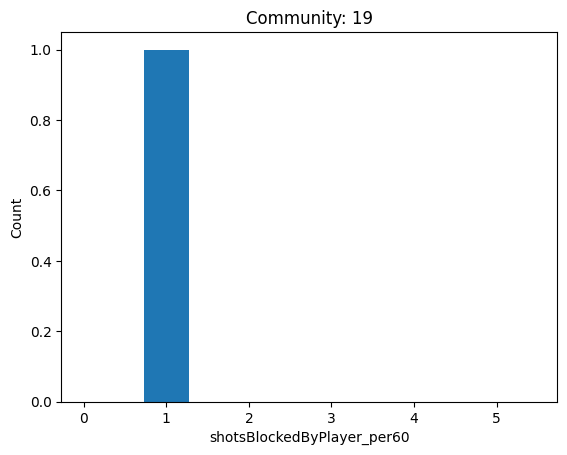

In [19]:
# Plot corsi influence distribution of entire playerbase
plot_distributions("shotsBlockedByPlayer_per60")
